In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Part 1 - 2 
1.
The data files contain errors and bugs that reflect common problems and challenges associated with electronic health records. Load and clean the data, both individually and linked. Where patients fail a quality control check, exclude them from the analyses.
a.
The output of this task is a clean clean patient demographics table for use in the next steps and sanitized condition, observation and medication files.
2.
Provide a comprehensive description of the patients, observations, and conditions tables - for example, provide the number of unique patients, the most frequent ontology terms (e.g. LOINC, SNOMED and RxNorm) and other information you think is important to describe.


### Codes 

I loaded the three code dictionaries: SNOMED (for conditions), LOINC (for observations), and RxNorm (for medications). I converted the codes to strings, and created dictionaries to map each code to its description. This will help me interpret the data more easily later on.


In [2]:
conds_codes = pd.read_csv('dest/dictionary_snomed.csv')
valid_snomed_codes = conds_codes['CODE'].astype(str).unique()
conds_codes['CODE'] = conds_codes['CODE'].astype(str)
snomed_dict = conds_codes.set_index('CODE')['DESCRIPTION'].to_dict()
# print(valid_snomed_codes[:5])

obs_codes = pd.read_csv('dest/dictionary_loinc.csv')
valid_loinc_codes = obs_codes['CODE'].unique()
obs_codes['CODE'] = obs_codes['CODE'].astype(str)
loinc_dict = obs_codes.set_index('CODE')['DESCRIPTION'].to_dict()
# print(valid_loinc_codes[:5])

meds_codes = pd.read_csv('dest/dictionary_rxnorm.csv')
valid_rxnorm_codes = meds_codes['CODE'].astype(str).unique()
meds_codes['CODE'] = meds_codes['CODE'].astype(str)
# print(valid_rxnorm_codes[:5])
rxnorm_dict = meds_codes.set_index('CODE')['DESCRIPTION'].to_dict()

## Patients
Data cleaning steps:
- Loaded patient data and selected relevant columns  
- Cleaned column names  
- Converted birthdate and deathdate to datetime, removing invalid or future birthdates  
- Calculated current age if person doesnt have dethdate. I used pd.datetime now to compute it
- If patient has deathdate, I computed death age as the difference between deathdate and birthdate.
- I dropped negative ages  
- Filtered out records with invalid or missing gender and race  
- Left marital status as is since it’s often missing and not a mandatory field
- Finished with 1097 patient records after cleaning  



In [3]:
patients = pd.read_csv('dest/patients.csv.gz')
#print(patients.columns.to_list())
patients = patients[['Id','BIRTHDATE','DEATHDATE','MARITAL','RACE','ETHNICITY', 'GENDER', 'BIRTHPLACE','CITY','STATE', 'COUNTY', 'ZIP']]
patients.columns = patients.columns.str.strip().str.lower().str.replace(' ', '_')
## 1162 records, with 1162 unique ids
## only 164 with a valid string (`YYYY-MM-DD`) for deathdate 1158 for birthdate
## 15 records with birthdate in the future were removed, deathdate didnt present this error
## 4 records removed because bithdate nat, currently 1143 records
patients['birthdate'] = pd.to_datetime(patients['birthdate'], format='%Y-%m-%d', errors='coerce')
patients['deathdate']  = pd.to_datetime(patients['deathdate'], format='%Y-%m-%d', errors='coerce')
patients = patients[(patients['birthdate'] < pd.Timestamp('now'))]
patients = patients[patients['birthdate'].notna()]
patients['death_age'] = (((patients['deathdate'] - patients['birthdate']) / pd.Timedelta(days=365.25)).round().astype('Int64'))
patients.loc[patients['death_age'].isna(), 'current_age'] = ( ((pd.Timestamp.today() - patients.loc[patients['death_age'].isna(), 'birthdate'])
                                                               / pd.Timedelta(days=365.25)).round().astype('Int64'))
## 1 record removed for negative death age, and cucrrent age
patients = patients[(patients['death_age']>0) | patients['death_age'].isna()]
patients = patients[(patients['current_age']>0) | patients['current_age'].isna()]
## removed 24 records with null or incorrect gender, currently 1118 records
patients = patients[(patients['gender'] == 'M') | (patients['gender'] == 'F')]
## removed 21 records with unvalid race
patients = patients[(patients['race'] == 'white') | (patients['race'] == 'black')| (patients['race'] == 'asian')
                    |(patients['race'] == 'hawaiian')| (patients['race'] == 'native')| (patients['race'] == 'other')]
## there are 355 records with null marital status, since it is not mandatory info i leave them
## currently 1097 records
patients.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1097 entries, 0 to 1161
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           1097 non-null   object        
 1   birthdate    1097 non-null   datetime64[ns]
 2   deathdate    153 non-null    datetime64[ns]
 3   marital      742 non-null    object        
 4   race         1097 non-null   object        
 5   ethnicity    1097 non-null   object        
 6   gender       1097 non-null   object        
 7   birthplace   1097 non-null   object        
 8   city         1097 non-null   object        
 9   state        1097 non-null   object        
 10  county       1097 non-null   object        
 11  zip          584 non-null    float64       
 12  death_age    153 non-null    Int64         
 13  current_age  944 non-null    Int64         
dtypes: Int64(2), datetime64[ns](2), float64(1), object(9)
memory usage: 130.7+ KB


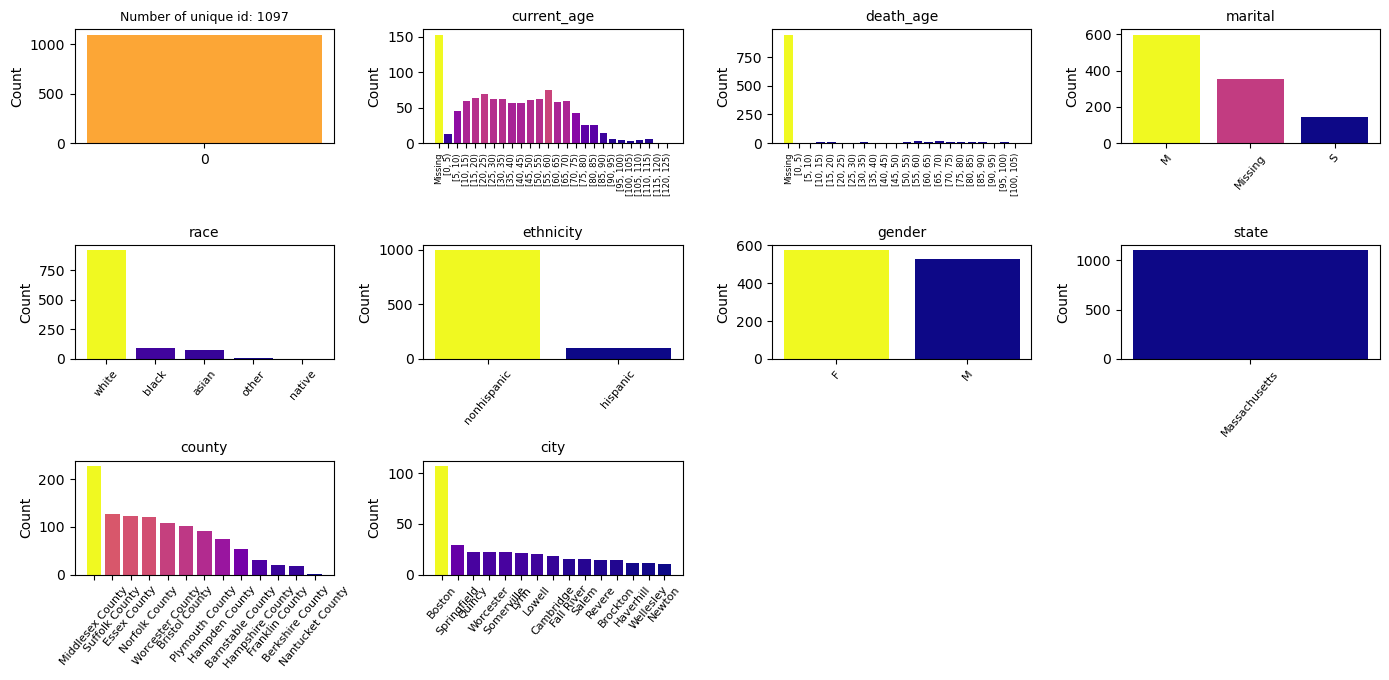

In [4]:
plot_cols = ['id', 'current_age', 'death_age', 'marital', 'race', 'ethnicity', 'gender', 'state', 'county', 'city']
n_cols = 4
n_rows = -(-len(plot_cols) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 2.3))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    ax = axes[i]
    if col == 'id':
        unique_count = patients['id'].nunique()
        ax.bar(0, unique_count, color=cm.plasma(0.8), width=0.4)  # numeric x=0, narrow bar
        ax.set_xticks([0])
        ax.set_title(f'Number of unique {col}: {unique_count}', fontsize=9)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=0)
        continue
    data = patients[col]
    if pd.api.types.is_numeric_dtype(data):
        binned = pd.cut(data, bins=range(0, int(data.max() + 5), 5), right=False)
        bin_counts = binned.value_counts().sort_index()
        bin_counts.index = bin_counts.index.astype(str)
        missing_count = data.isna().sum()
        top_counts = pd.concat([pd.Series({'Missing': missing_count}),bin_counts ])
        tick_rotation = 90
        x_fontsize = 6
    else:
        top_counts = data.fillna('Missing').astype(str).value_counts().head(15)
        tick_rotation = 50
        x_fontsize = 8
    norm = mcolors.Normalize(vmin=top_counts.values.min(), vmax=top_counts.values.max())
    colors = [cm.plasma(norm(v)) for v in top_counts.values]
    
    ax.bar(top_counts.index, top_counts.values, color=colors)
    ax.set_title(col, fontsize=10)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=tick_rotation, labelsize=x_fontsize)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- For 153 patients with missing current age (because they are deceased), I used their age at death instead  
- Current age ranges evenly between 10 and 70  
- Most patients are married  
- Race is mostly white, and ethnicity is mainly non-Hispanic  
- Majority of patients are female  
- All patients are from Massachusetts, mostly in Middlesex county and Boston city  


## Conditions

- I loaded the conditions data, which has 38,100 records for 1,147 patients across 26,904 encounters.

- I cleaned the column names and converted the start and stop dates to datetime, allowing missing stop dates.

- I removed records without a condition code.

- Then, I converted condition codes to strings and kept only those that appear in the SNOMED dictionary.

-  filtered the data to include only patients present in my cleaned patient list.

- Finally, I mapped each condition code to its SNOMED diagnosis label. I noticed that some of them included extra info **between parentheses**, for example if code correspond to disorder, finding, situation. So I used a text pattern to extract that information and saved it in **'snomed_diagnosis_label_type'**


In [5]:
conditions = pd.read_csv('dest/conditions.csv.gz')
#38100 records that correspond to 1147 patients, in 26904 encounters
## didnt found errors in condition start, stop dates. But 8169 conditions dont have stop date
conditions.columns = conditions.columns.str.strip().str.lower().str.replace(' ', '_')
conditions['start'] = pd.to_datetime(conditions['start'], format='%Y-%m-%d', errors='coerce')
conditions['stop'] = pd.to_datetime(conditions['stop'], format='%Y-%m-%d', errors='coerce')
conditions.rename(columns={'start':'condition_start','stop':'condition_stop','code':'condition_code'}, inplace=True)
## removed 48 records that didn include code
conditions = conditions[conditions['condition_code'].notna()]
conditions['condition_code'] = pd.to_numeric(conditions['condition_code']).astype('Int64').astype(str)
## 15 records removed because their codes didnt appear in snomed dict
## total of 38037 records, allowes some condition_stop null values
conditions = conditions[conditions['condition_code'].isin(valid_snomed_codes)]
# after by patients in patients id 36346
conditions = conditions[conditions['patient'].isin(patients['id'].unique())]
conditions['snomed_diagnosis_label'] = conditions['condition_code'].map(lambda x: snomed_dict.get(x, 'NotInDict')).astype(str)#
conditions['snomed_diagnosis_label_type'] = conditions['snomed_diagnosis_label'].apply(lambda x: ( 'other' if (matches := re.findall(r'\(([^()]*)\)', x)) 
        and matches[-1] in ['panic', 'person']else matches[-1] if matches else 'not label' ))
conditions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36346 entries, 12 to 38099
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   condition_start              36346 non-null  datetime64[ns]
 1   condition_stop               28590 non-null  datetime64[ns]
 2   patient                      36346 non-null  object        
 3   encounter                    36346 non-null  object        
 4   condition_code               36346 non-null  object        
 5   snomed_diagnosis_label       36346 non-null  object        
 6   snomed_diagnosis_label_type  36346 non-null  object        
dtypes: datetime64[ns](2), object(5)
memory usage: 2.2+ MB


The clean data corresponds to 36346 conditions, for 1081 patients and 25682 encounters.

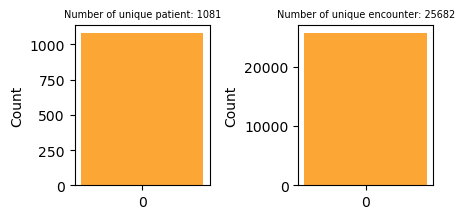

In [6]:
plot_cols = ['patient', 'encounter']
n_cols = 4
n_rows = -(-len(plot_cols) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, n_rows * 2.3))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    ax = axes[i]
    if col == 'patient' or col=='encounter':
        unique_count = conditions[col].nunique()
        ax.bar(0, unique_count, color=cm.plasma(0.8), width=0.4)  # numeric x=0, narrow bar
        ax.set_xticks([0])
        ax.set_title(f'Number of unique {col}: {unique_count}', fontsize=7)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=0)
        continue
    data = conditions[col]
    top_counts = data.fillna('Missing').astype(str).value_counts().head(15)
    tick_rotation = 50
    x_fontsize = 8
    norm = mcolors.Normalize(vmin=top_counts.values.min(), vmax=top_counts.values.max())
    colors = [cm.plasma(norm(v)) for v in top_counts.values]
    
    ax.bar(top_counts.index.str[:15], top_counts.values, color=colors)
    ax.set_title(col, fontsize=10)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=tick_rotation, labelsize=x_fontsize)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

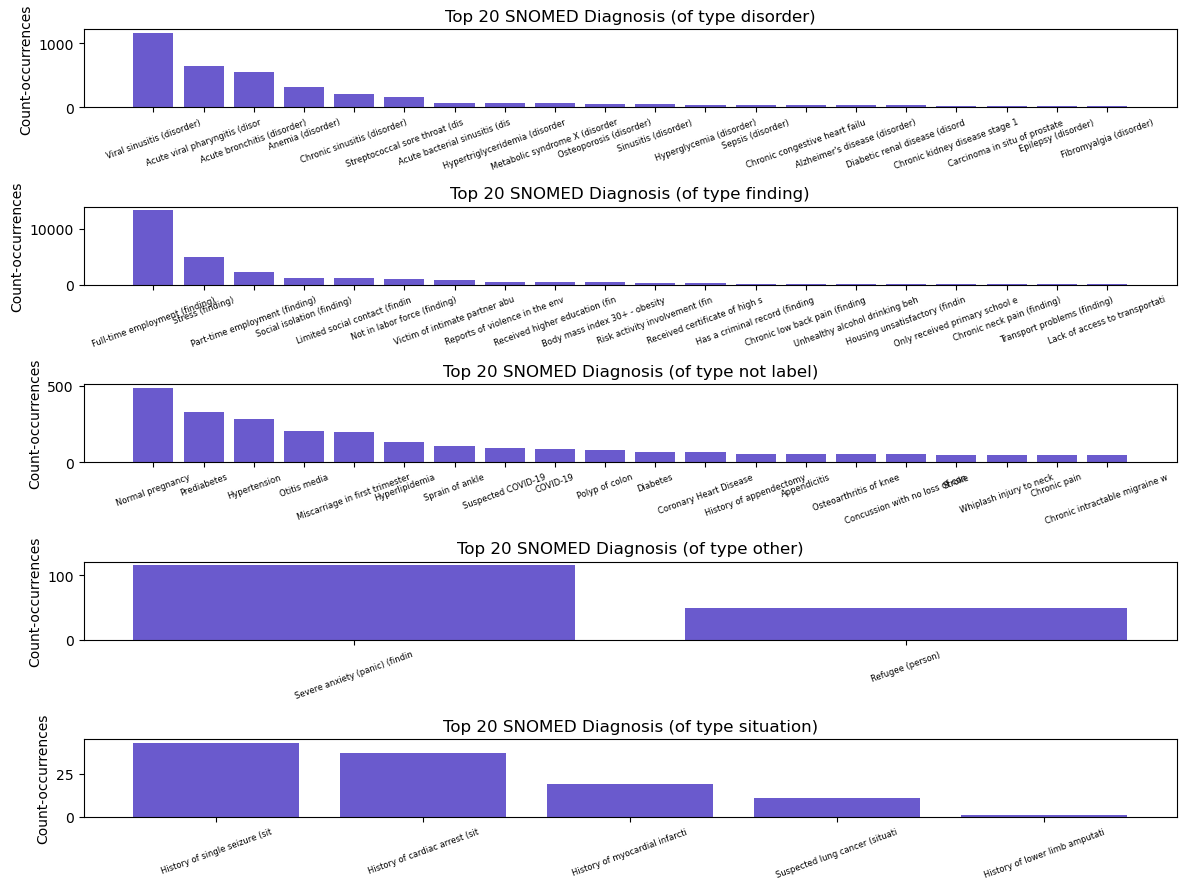

In [7]:
summary = conditions.groupby(['snomed_diagnosis_label_type', 'snomed_diagnosis_label']).agg({'patient': 'count'  # count all occurrences, not unique patients
    }).rename(columns={'patient': 'total_occurrences'}).reset_index()

types = summary['snomed_diagnosis_label_type'].unique()
fig, axes = plt.subplots(len(types), 1, figsize=(12, 1.8 * len(types)))

for i, t in enumerate(types):
    data = summary[summary['snomed_diagnosis_label_type'] == t].sort_values(by='total_occurrences', ascending=False).head(20)
    axes[i].bar(data['snomed_diagnosis_label'].str[:30], data['total_occurrences'], color='slateblue')
    axes[i].set_title(f'Top 20 SNOMED Diagnosis (of type {t})')
    axes[i].set_ylabel('Count-occurrences')
    axes[i].tick_params(axis='x', rotation=20, labelsize=6)

plt.tight_layout()
plt.show()

- Most of the terms in the conditions dataset come from questionnaires, such as full-time employment, stress, and part-time employment.

- The most common disorders are viral sinusitis, acute viral pharyngitis, acute bronchitis, and anemia.

- The ones labeled as "situation" correspond to histories of seizure, cardiac arrest, myocardial infarction, cancer, etc.

- The terms without parentheses or extra info correspond to conditions like prediabetes, pregnancy, or hypertension.

## Observations

- I loaded the observations data, which initially had over 530,000 records.

- I cleaned up the column names and prefixed key columns with "observation_" for clarity.

- The observation dates were converted to datetime without issues.

- I removed records with codes not found in the LOINC dictionary, reducing the data to about 498,000 records.

- Then, I filtered to keep only observations from patients in my cleaned patient list, ending with around 472,000 records

- I allowed records without units because these correspond to text from qeustionaries

- Finally, I mapped each observation code to its description using the LOINC dictionary.


In [8]:
observations = pd.read_csv('dest/observations.csv.gz')
## initially 531144 records
observations.columns = observations.columns.str.strip().str.lower().str.replace(' ', '_')
observations.rename(columns={col:'observation_'+col for col in ['date','category','code','value','units','type']}, inplace=True)
## didnt find any issues with date
observations['observation_date'] = pd.to_datetime(observations['observation_date'], utc=True, errors='coerce')
## 32560 records removed because codes disnt appear in loinc dictionary
## currently 498584 records
observations = observations[observations['observation_code'].isin(valid_loinc_codes)]
## 472010 records corresponding to patients id
observations = observations[observations['patient'].isin(patients['id'].unique())]
observations['observation_label'] = observations['observation_code'].map(lambda x: loinc_dict.get(x, 'NotInDict')).astype(str)
observations.info()


<class 'pandas.core.frame.DataFrame'>
Index: 472010 entries, 0 to 531110
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   observation_date      472010 non-null  datetime64[ns, UTC]
 1   patient               472010 non-null  object             
 2   encounter             472010 non-null  object             
 3   observation_category  472010 non-null  object             
 4   observation_code      472010 non-null  object             
 5   observation_value     472010 non-null  object             
 6   observation_units     297396 non-null  object             
 7   observation_type      472010 non-null  object             
 8   observation_label     472010 non-null  object             
dtypes: datetime64[ns, UTC](1), object(8)
memory usage: 36.0+ MB


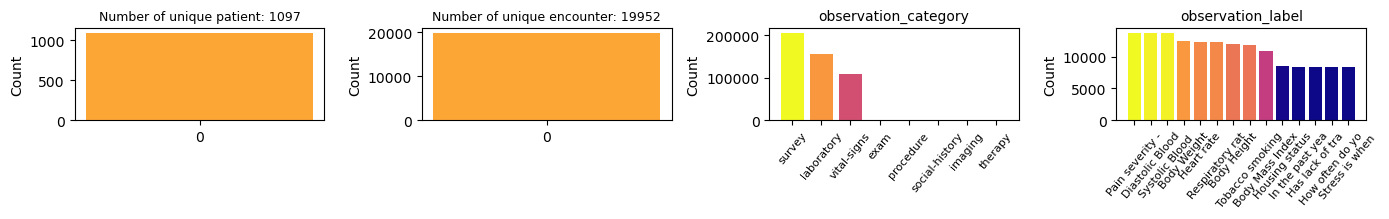

In [9]:
plot_cols = ['patient', 'encounter', 'observation_category','observation_label']
n_cols = 4
n_rows = -(-len(plot_cols) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 2.3))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    ax = axes[i]
    if col == 'patient' or col=='encounter':
        unique_count = observations[col].nunique()
        ax.bar(0, unique_count, color=cm.plasma(0.8), width=0.4)  # numeric x=0, narrow bar
        ax.set_xticks([0])
        ax.set_title(f'Number of unique {col}: {unique_count}', fontsize=9)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=0)
        continue
    data = observations[col]
    top_counts = data.fillna('Missing').astype(str).value_counts().head(15)
    tick_rotation = 50
    x_fontsize = 8
    norm = mcolors.Normalize(vmin=top_counts.values.min(), vmax=top_counts.values.max())
    colors = [cm.plasma(norm(v)) for v in top_counts.values]
    
    ax.bar(top_counts.index.str[:15], top_counts.values, color=colors)
    ax.set_title(col, fontsize=10)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=tick_rotation, labelsize=x_fontsize)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

My final dataset for observations has around 472,000 rows, corresponding to 1,097 patients and 19,952 records. 

The category with the most rows is 'survey' followed by 'laboratory'. 

For the observation labels, the top three were 'Pain severity', 'Diastolic blood pressure', and 'Systolic blood pressure'.

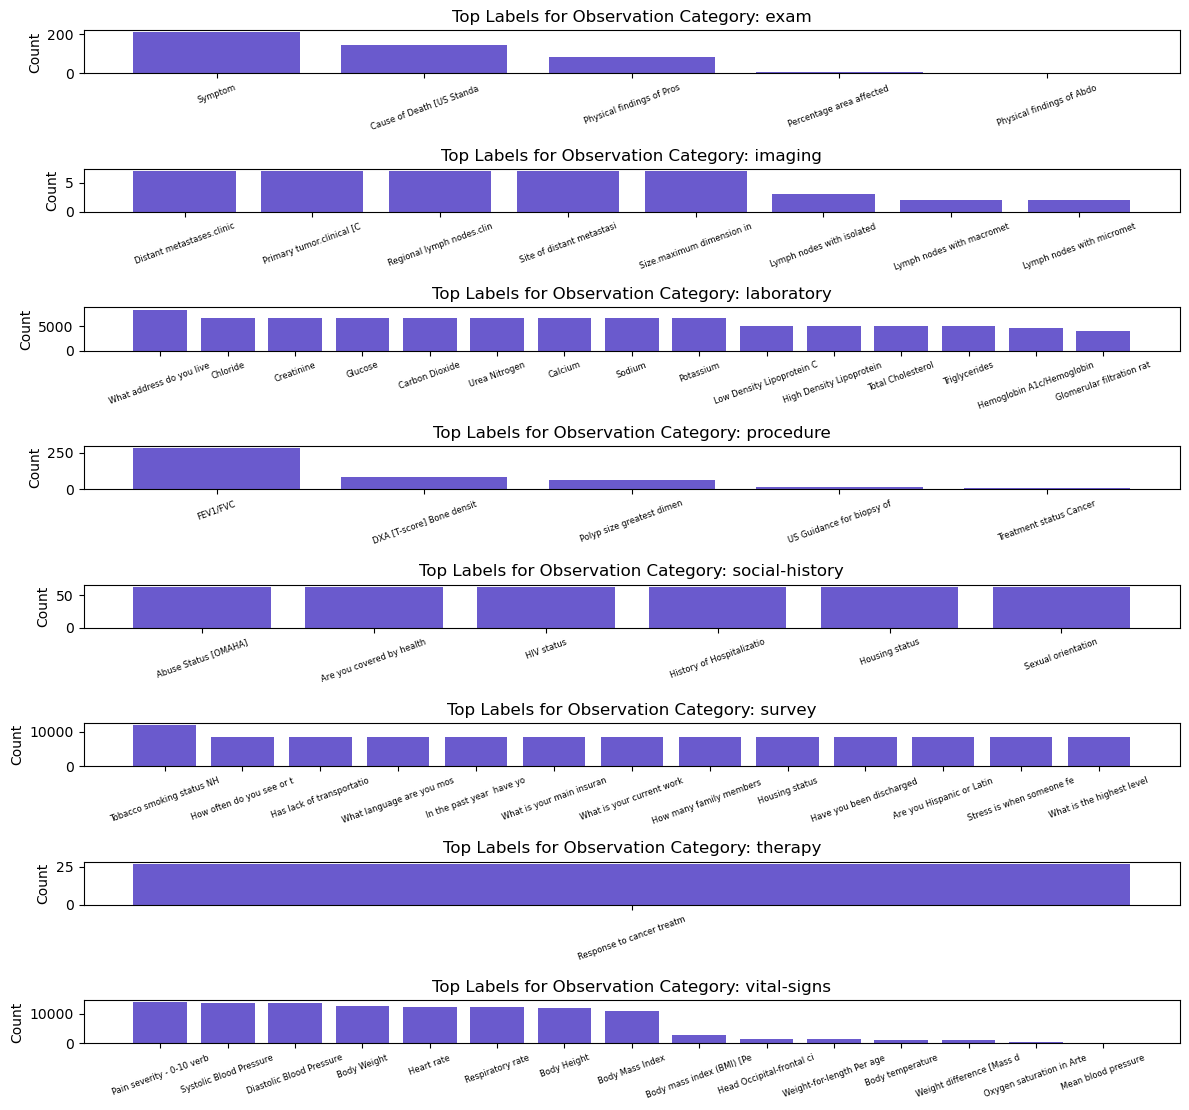

In [10]:
summary = observations.groupby(['observation_category', 'observation_label']).size().reset_index(name='count')

types = summary['observation_category'].unique()
fig, axes = plt.subplots(len(types), 1, figsize=(12, 1.4 * len(types)))

for i, t in enumerate(types):
    data = summary[summary['observation_category'] == t].sort_values(by='count', ascending=False).head(15)
    axes[i].bar(data['observation_label'].str[:25], data['count'], color='slateblue')
    axes[i].set_title(f'Top Labels for Observation Category: {t}')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=20, labelsize=6)

plt.tight_layout()
plt.show()

I plotted the top labels for different observation categories.

For example for vital signs the tops labels are:
- 'Pain severity - 0-10 verbal numeric rating [Score]'
-  Reported'
-  'Systolic Blood Pressure'
-  'Diastolic Blood Pressure'
-  'Body Weight'
-  'Heart rate'

## Medications

- I loaded the medications data and cleaned the column names. I kept only the relevant columns and renamed some for clarity.
- Removed records without medication codes, I converted start and stop dates to datetime and verified all are in the past.
- I filtered the data to keep only valid medication  from RxNorm dictionary
- Removed records where reason code was incorrect (not in SNOMED dict), but I allowed to have rows where reason code was null.
- Records with negative dispenses were removed.I filtered out outliers in dispenses, this is because I found one record with 45000 dispenses.
- After filtering for patients in my dataset, I mapped medication and reason codes to their labels.


In [11]:
medications = pd.read_csv('dest/medications.csv.gz')
medications.columns = medications.columns.str.strip().str.lower().str.replace(' ', '_')
medications = medications[['start','stop','patient','encounter','code','dispenses','reasoncode']]
##there are 56430 medications records
medications.rename(columns={'code': 'medication_code','start':'medication_start','stop':'medication_stop'}, inplace=True)
## 48 records without medication code where removed, 56382 recordds
medications = medications[medications['medication_code'].notna()]
## verified that all the timestamps where in the past
medications['medication_start'] = pd.to_datetime(medications['medication_start'], utc=True, errors='coerce')
medications['medication_stop'] = pd.to_datetime(medications['medication_stop'], utc=True, errors='coerce')

##  rxnorm codes are integers and medication code float so i have to fix
## 16 records with unvalid codes were removed
medications['medication_code'] =  pd.to_numeric(medications['medication_code'], errors='coerce').astype('Int64').astype(str)
medications = medications[medications['medication_code'].isin(valid_rxnorm_codes)]
## removed 9 records where reasoncade was not in snomed or it wasnt null
medications['reasoncode'] = pd.to_numeric(medications['reasoncode']).astype('Int64').astype(str)
medications['reasoncode'] = medications['reasoncode'].replace('<NA>', pd.NA).fillna('MissingValue')
medications = medications[(medications['reasoncode'].isin(valid_snomed_codes)) | (medications['reasoncode']=='MissingValue')]
# 6 records with negative dispenses removed
medications = medications[medications['dispenses']>0]
# removing upper bound outliers for dispenses because max is 45000; currently 43721 records
Q1 = medications['dispenses'].quantile(0.25)
Q3 = medications['dispenses'].quantile(0.75)
IQR = Q3 - Q1
medications = medications[medications['dispenses']<=Q3+(1.5*IQR)]
## finalized with 42044 records
medications = medications[medications['patient'].isin(patients['id'].unique())]
# Map and truncate labels
medications['med_label'] = medications['medication_code'].map(lambda x: rxnorm_dict.get(x, 'NotInDict')).astype(str)
medications['reason_snomed_diagnosis_label'] = medications['reasoncode'].map(lambda x: snomed_dict.get(x, 'NotInDict')).astype(str)#
medications['reason_diagnosis_label_type'] = medications['reason_snomed_diagnosis_label'].apply(lambda x: ( 'other' if (matches := re.findall(r'\(([^()]*)\)', x)) 
        and matches[-1] in ['panic', 'person']else matches[-1] if matches else 'not label' ))
medications.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42044 entries, 0 to 56429
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   medication_start               42044 non-null  datetime64[ns, UTC]
 1   medication_stop                40349 non-null  datetime64[ns, UTC]
 2   patient                        42044 non-null  object             
 3   encounter                      42044 non-null  object             
 4   medication_code                42044 non-null  object             
 5   dispenses                      42044 non-null  int64              
 6   reasoncode                     42044 non-null  object             
 7   med_label                      42044 non-null  object             
 8   reason_snomed_diagnosis_label  42044 non-null  object             
 9   reason_diagnosis_label_type    42044 non-null  object             
dtypes: datetime64[ns, UTC](2), 

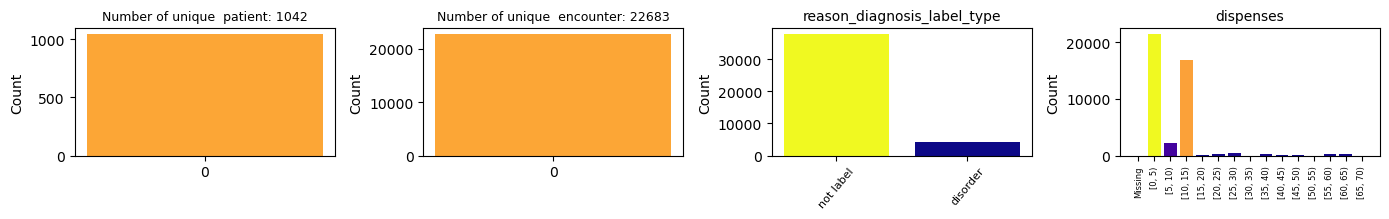

In [12]:
plot_cols = ['patient', 'encounter', 'reason_diagnosis_label_type', 'dispenses']
n_cols = 4
n_rows = -(-len(plot_cols) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 2.3))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    ax = axes[i]
    if col in ['patient', 'encounter']:
        unique_count = medications[col].nunique()
        ax.bar(0, unique_count, color=cm.plasma(0.8), width=0.4)
        ax.set_xticks([0])
        ax.set_title(f'Number of unique  {col}: {unique_count}', fontsize=9)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=0)
        continue

    data = medications[col]
    if pd.api.types.is_numeric_dtype(data):
        binned = pd.cut(data, bins=range(0, int(data.max() + 5), 5), right=False)
        bin_counts = binned.value_counts().sort_index()
        bin_counts.index = bin_counts.index.astype(str)
        missing_count = data.isna().sum()
        top_counts = pd.concat([pd.Series({'Missing': missing_count}), bin_counts])
        tick_labels = top_counts.index
        tick_rotation = 90
        x_fontsize = 6
    else:
        top_counts = data.fillna('Missing').astype(str).value_counts().head(20)
        tick_labels = top_counts.index.str[:15]  # truncate labels
        tick_rotation = 50
        x_fontsize = 8

    norm = mcolors.Normalize(vmin=top_counts.values.min(), vmax=top_counts.values.max())
    colors = [cm.plasma(norm(v)) for v in top_counts.values]

    ax.bar(tick_labels, top_counts.values, color=colors)
    ax.set_title(col, fontsize=10)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=tick_rotation, labelsize=x_fontsize)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


My cleaned medication dataset has 42044 entries, these correspond to 1042 patients and 22683 encounters.

The top three medication labels with more ocurreences are: Hydrochirothia, Insulin and Metformin.

The top three labels for reason with more ocurrences are hypertension, diabetes and chilhodd asthma.

And the top three number of dispenses are between 0-5,11-15, and 6-10. 

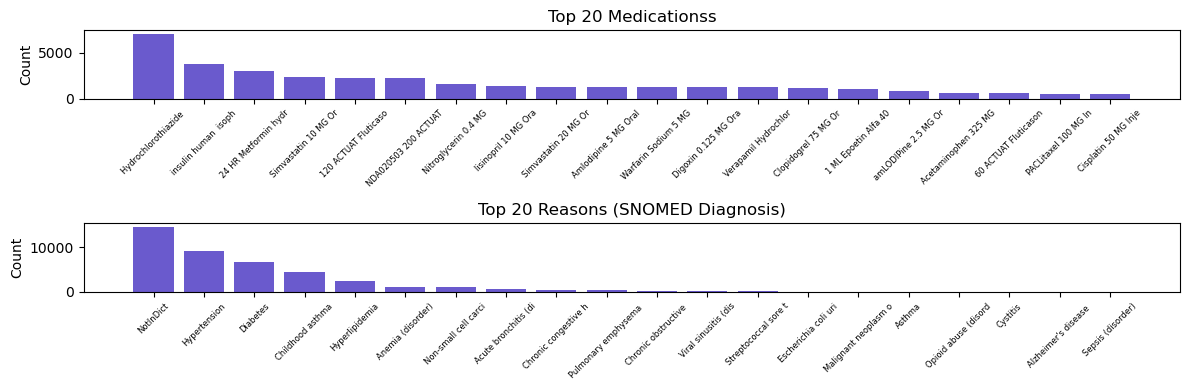

In [13]:
med_summary = medications.groupby('med_label')['patient'].count().reset_index(name='total_occurrences')
med_summary = med_summary.sort_values(by='total_occurrences', ascending=False).head(20)

reason_summary = medications.groupby('reason_snomed_diagnosis_label')['patient'].count().reset_index(name='total_occurrences')
reason_summary = reason_summary.sort_values(by='total_occurrences', ascending=False).head(20)

fig, axes = plt.subplots(2, 1, figsize=(12, 4))

axes[0].bar(med_summary['med_label'].str[:20], med_summary['total_occurrences'], color='slateblue')
axes[0].set_title('Top 20 Medicationss')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45, labelsize=6)

axes[1].bar(reason_summary['reason_snomed_diagnosis_label'].str[:20], reason_summary['total_occurrences'], color='slateblue')
axes[1].set_title('Top 20 Reasons (SNOMED Diagnosis)')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45, labelsize=6)

plt.tight_layout()
plt.show()


## Encounters

- I loaded the encounters data and selected only the relevant columns, then cleaned up column names and renamed a few for clarity.
- The start and stop dates were converted to datetime without issues.
- I removed 63 records where reason codes weren’t valid SNOMED terms (excluding missing ones, which I labeled as 'MissingValue').
- Most of the encounter codes aren’t in the SNOMED dictionary — they mainly correspond to encounter classes like wellness, urgent care, and outpatient. I decided to keep them but won’t rely on this column for analysis.
- I filtered the data to include only patients from my cleaned patient dataset.
- Finally, I mapped the reason codes to SNOMED labels and extracted diagnosis label types for further grouping.


In [14]:
encounters = pd.read_csv('dest/encounters.csv.gz')
encounters = encounters[['Id', 'START', 'STOP', 'PATIENT', 'ENCOUNTERCLASS', 'CODE', 'REASONCODE']]
encounters.columns = encounters.columns.str.strip().str.lower().str.replace(' ', '_')
encounters.rename(columns={col:'encounter_'+col for col in ['id','start','stop','code']}, inplace=True)
## 61459 records
## didnt find errors in date
encounters['encounter_start'] = pd.to_datetime(encounters['encounter_start'], utc=True, errors='coerce')
encounters['encounter_stop'] = pd.to_datetime(encounters['encounter_stop'], utc=True, errors='coerce')
## 63 rows reason codes not null and not in snomed codes were removed
encounters['reasoncode'] =  pd.to_numeric(encounters['reasoncode']).astype('Int64').astype(str)
encounters['reasoncode'] = encounters['reasoncode'].replace('<NA>', pd.NA).fillna('MissingValue')
encounters = encounters[(encounters['reasoncode'].isin(valid_snomed_codes))| (encounters['reasoncode']=='MissingValue')]
## 44 of the codes (encounter_codes) not in snomed, this correspond to 61294 rows
## mostly correspond to encounterclass: welleness, urgentcare, outpatient
## decided to keeps records but its a significant portion of data but avoid use column in data analysis
encounters['encounter_code'] =  pd.to_numeric(encounters['encounter_code']).astype('Int64').astype(str)
encounters['encounter_code'] = encounters['encounter_code'].replace('<NA>', pd.NA).fillna('MissingValue')
## total 58344 records for patients in patients ids
encounters = encounters[encounters['patient'].isin(patients['id'].unique())]
encounters['reason_snomed_diagnosis_label'] = encounters['reasoncode'].map(lambda x: snomed_dict.get(x, 'NotInDict')).astype(str)#
encounters['reason_diagnosis_label_type'] = encounters['reason_snomed_diagnosis_label'].apply(lambda x: ( 'other' if (matches := re.findall(r'\(([^()]*)\)', x)) 
        and matches[-1] in ['panic', 'person']else matches[-1] if matches else 'not label' ))
encounters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58344 entries, 0 to 61458
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   encounter_id                   58344 non-null  object             
 1   encounter_start                58344 non-null  datetime64[ns, UTC]
 2   encounter_stop                 58344 non-null  datetime64[ns, UTC]
 3   patient                        58344 non-null  object             
 4   encounterclass                 58344 non-null  object             
 5   encounter_code                 58344 non-null  object             
 6   reasoncode                     58344 non-null  object             
 7   reason_snomed_diagnosis_label  58344 non-null  object             
 8   reason_diagnosis_label_type    58344 non-null  object             
dtypes: datetime64[ns, UTC](2), object(7)
memory usage: 4.5+ MB


The encounters clean data set contains 58344 records corresponding to 1097 patients.

The top 3 encounter class are: wellness, ambulatory and outpatient. And most of the reasoncode are not in the snomed dictioctionary.

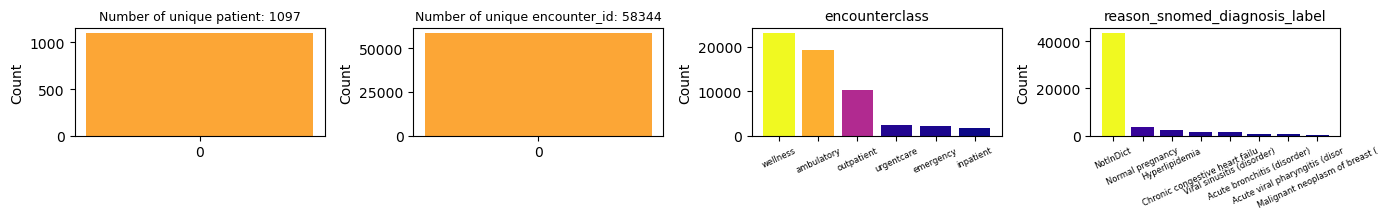

In [15]:
plot_cols = ['patient', 'encounter_id','encounterclass','reason_snomed_diagnosis_label']#, 'dispenses']
n_cols = 4
n_rows = -(-len(plot_cols) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 2.3))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    ax = axes[i]
    if col in ['patient', 'encounter_id']:
        unique_count = encounters[col].nunique()
        ax.bar(0, unique_count, color=cm.plasma(0.8), width=0.4)
        ax.set_xticks([0])
        ax.set_title(f'Number of unique {col}: {unique_count}', fontsize=9)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=0)
        continue

    data = encounters[col]
    if pd.api.types.is_numeric_dtype(data):
        binned = pd.cut(data, bins=range(0, int(data.max() + 5), 5), right=False)
        bin_counts = binned.value_counts().sort_index()
        bin_counts.index = bin_counts.index.astype(str)
        missing_count = data.isna().sum()
        top_counts = pd.concat([pd.Series({'Missing': missing_count}), bin_counts])
        tick_labels = top_counts.index
        tick_rotation = 90
        x_fontsize = 6
    else:
        top_counts = data.fillna('Missing').astype(str).value_counts().head(8)
        tick_labels = top_counts.index.str[:30]  # truncate labels
        tick_rotation = 25
        x_fontsize = 6

    norm = mcolors.Normalize(vmin=top_counts.values.min(), vmax=top_counts.values.max())
    colors = [cm.plasma(norm(v)) for v in top_counts.values]

    ax.bar(tick_labels, top_counts.values, color=colors)
    ax.set_title(col, fontsize=10)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=tick_rotation, labelsize=x_fontsize)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Part 3:
### 3. Using the cleaned data from the first task, explore and compare the distribution of: a) systolic and diastolic blood pressure and b) BMI measurements in patients with diagnosed hypertension.

First, I needed to create a dataframe with the information needed. 
- I filtered the conditions data to get the patients diagnosed with hypertension and date when the condition started.
- Then from observations I selected patients diagnosed with hypertension, and also only observations happening after the condition started. I kept only the relevant observation types: Systolic and Diastolic Blood Pressure, and Body Mass Index.

The output was a dataframe with observations only for patients with hypertension, and observations with date greater or equal of when condition started.


In [16]:
hypertension_info = conditions[(conditions['snomed_diagnosis_label']=='Hypertension')][['patient','condition_start']].reset_index(drop=True)
hypertension_info['condition_start'] = pd.to_datetime(hypertension_info['condition_start']).dt.tz_localize('UTC')

obs_hyp = observations[['patient','observation_value','observation_label','observation_date']].merge(hypertension_info, on='patient', how='inner')
obs_hyp = obs_hyp[obs_hyp['observation_date'] >= obs_hyp['condition_start']]
#some values lack of BMI, this is because they dindht have height or weight
obs_hyp = obs_hyp[obs_hyp['observation_label'].isin(['Diastolic Blood Pressure','Systolic Blood Pressure','Body Mass Index'])].reset_index(drop=True)
obs_hyp.head()

,patient,observation_value,observation_label,observation_date,condition_start
0,339144f8-50e1-633e-a013-f361391c4cff,34.2,Body Mass Index,2016-07-04 05:03:31+00:00,2016-07-04 00:00:00+00:00
1,339144f8-50e1-633e-a013-f361391c4cff,106.0,Diastolic Blood Pressure,2016-07-04 05:03:31+00:00,2016-07-04 00:00:00+00:00
2,339144f8-50e1-633e-a013-f361391c4cff,158.0,Systolic Blood Pressure,2016-07-04 05:03:31+00:00,2016-07-04 00:00:00+00:00
3,339144f8-50e1-633e-a013-f361391c4cff,109.0,Diastolic Blood Pressure,2016-08-03 05:03:31+00:00,2016-07-04 00:00:00+00:00
4,339144f8-50e1-633e-a013-f361391c4cff,174.0,Systolic Blood Pressure,2016-08-03 05:03:31+00:00,2016-07-04 00:00:00+00:00


In [17]:
obs_hyp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11850 entries, 0 to 11849
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   patient            11850 non-null  object             
 1   observation_value  11850 non-null  object             
 2   observation_label  11850 non-null  object             
 3   observation_date   11850 non-null  datetime64[ns, UTC]
 4   condition_start    11850 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), object(3)
memory usage: 463.0+ KB


- I pivoted the observation data to have one row per patient and observation date, with BMI, systolic, and diastolic pressure as columns.
- For some dates the BMI was missing. So I kept only rows with BMI values.
- Then I merged with condition_start dates and patient demographic info.
- I checked for any observation dates that didn’t make sense (like observation dates happening before birth or after death).
- Then I calculated how many months since the hypertension diagnosis each observation was taken, and also the patient’s age at that time.
- I found one patient with  Systolic blood pressure of 300, which seemed incorrect. So I removed outliers in BMI and blood pressure using the IQR rule (e.g., systolic values like 300 were dropped).


In [18]:
obs_hyp_pivot= obs_hyp.pivot_table(index=['patient', 'observation_date'], columns='observation_label',
                            values='observation_value').reset_index()
obs_hyp_pivot = obs_hyp_pivot[obs_hyp_pivot['Body Mass Index'].notna()]
obs_hyp_pivot = obs_hyp_pivot.merge(obs_hyp[['patient', 'observation_date', 'condition_start']].drop_duplicates(),
            on=['patient', 'observation_date'],how='left')
obs_hyp_pivot = obs_hyp_pivot.merge(patients[['id', 'birthdate', 'deathdate', 'marital', 'race', 'ethnicity','gender']],
            left_on='patient', right_on='id', how='inner')
obs_hyp_pivot['birthdate'] = pd.to_datetime(obs_hyp_pivot['birthdate']).dt.tz_localize('UTC')
obs_hyp_pivot['deathdate'] = pd.to_datetime(obs_hyp_pivot['deathdate']).dt.tz_localize('UTC')
#checked for measuraments date that seem incorrect using birthdate and deathrate
obs_hyp_pivot['incorrect_obs_date'] = ((obs_hyp_pivot['observation_date'] < obs_hyp_pivot['birthdate']) |
                                       (obs_hyp_pivot['observation_date'] > obs_hyp_pivot['deathdate']))
obs_hyp_pivot['months_since_condition_start'] = obs_hyp_pivot.apply(lambda row: (row['observation_date'] - row['condition_start']).days // 30,axis=1)
obs_hyp_pivot['age_at_observation_date'] = obs_hyp_pivot.apply(lambda row: (row['observation_date'] - row['birthdate']).days // 365.25,axis=1)
cols = ['Body Mass Index', 'Diastolic Blood Pressure', 'Systolic Blood Pressure']
obs_hyp_pivot[cols] = obs_hyp_pivot[cols].astype(float)
## Systolic blood pressure of 300 seems incorrect, i will treat like outlier and remove it
cols = ['Body Mass Index', 'Diastolic Blood Pressure', 'Systolic Blood Pressure']
for col in cols:
    Q1, Q3 = obs_hyp_pivot[col].quantile(0.25), obs_hyp_pivot[col].quantile(0.75)
    lower_bound, upper_bound = Q1 - 1.5 * (Q3-Q1), Q3 + 1.5 * (Q3-Q1)
    obs_hyp_pivot = obs_hyp_pivot[(obs_hyp_pivot[col] >= lower_bound) & (obs_hyp_pivot[col] <= upper_bound)]
obs_hyp_pivot.head()

,patient,observation_date,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,condition_start,id,birthdate,deathdate,marital,race,ethnicity,gender,incorrect_obs_date,months_since_condition_start,age_at_observation_date
0,00126cb9-8460-4747-e302-c3609684531e,2012-09-01 23:28:56+00:00,27.7,78.0,112.0,2005-07-23 00:00:00+00:00,00126cb9-8460-4747-e302-c3609684531e,1987-05-30 00:00:00+00:00,NaT,M,white,nonhispanic,F,False,86,25.0
1,00126cb9-8460-4747-e302-c3609684531e,2013-09-07 23:28:56+00:00,27.7,86.0,130.0,2005-07-23 00:00:00+00:00,00126cb9-8460-4747-e302-c3609684531e,1987-05-30 00:00:00+00:00,NaT,M,white,nonhispanic,F,False,98,26.0
2,00126cb9-8460-4747-e302-c3609684531e,2014-09-13 23:28:56+00:00,27.7,70.0,121.0,2005-07-23 00:00:00+00:00,00126cb9-8460-4747-e302-c3609684531e,1987-05-30 00:00:00+00:00,NaT,M,white,nonhispanic,F,False,111,27.0
3,00126cb9-8460-4747-e302-c3609684531e,2015-09-19 23:28:56+00:00,27.7,83.0,118.0,2005-07-23 00:00:00+00:00,00126cb9-8460-4747-e302-c3609684531e,1987-05-30 00:00:00+00:00,NaT,M,white,nonhispanic,F,False,123,28.0
4,00126cb9-8460-4747-e302-c3609684531e,2016-09-24 23:28:56+00:00,27.7,76.0,111.0,2005-07-23 00:00:00+00:00,00126cb9-8460-4747-e302-c3609684531e,1987-05-30 00:00:00+00:00,NaT,M,white,nonhispanic,F,False,136,29.0


In [19]:
print('Number of participants with at least one date that contained BMI, Diastolic and Systolic ', len(obs_hyp_pivot['patient'].unique()) )

Number of participants with at least one date that contained BMI, Diastolic and Systolic  238


The resulting table contains **3005 records for 238 patients** in different dates. Each record contains demographics and BMI, Diastolic and Systolic blood pressure.

Most of the patients have between 1 to 20 observations. And most of the observations happened around 400 months after condition started.

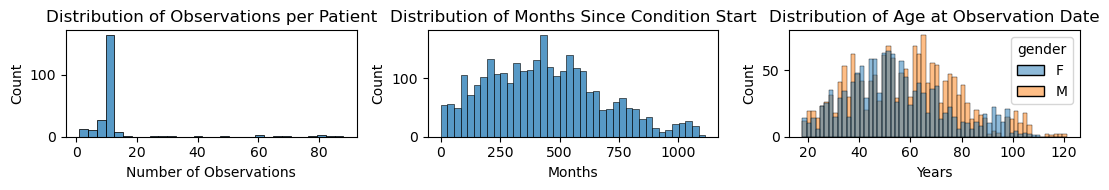

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(11, 2))

# Distribution of number of rows per patient
patient_counts = obs_hyp_pivot['patient'].value_counts()
# Plot distribution of counts
sns.histplot(patient_counts, bins=30, ax=axes[0])
axes[0].set_title('Distribution of Observations per Patient')
axes[0].set_xlabel('Number of Observations')

# Distribution of months since condition start
sns.histplot(obs_hyp_pivot['months_since_condition_start'], bins=40, ax=axes[1])
axes[1].set_title('Distribution of Months Since Condition Start')
axes[1].set_xlabel('Months')

# Distribution of ages
# You must pass the full DataFrame and specify x and hue as column names
sns.histplot(data=obs_hyp_pivot, x='age_at_observation_date', hue='gender', bins=60, ax=axes[2])
axes[2].set_title('Distribution of Age at Observation Date')
axes[2].set_xlabel('Years')


plt.tight_layout()
plt.show()

- I categorized patients into age groups based on their age at the time of observation: 0–19, 20–39, 40–59, 60–79, and 80+.
- I created histograms to visualize the distribution of BMI, systolic, and diastolic blood pressure within each age group.
- Each histogram include a comparison between genders.
- Distributions from male and female are very similar.
- Patients in the age group 0-19 years have higher blood pressure even when BMI distribution is lower when compared to other groups.

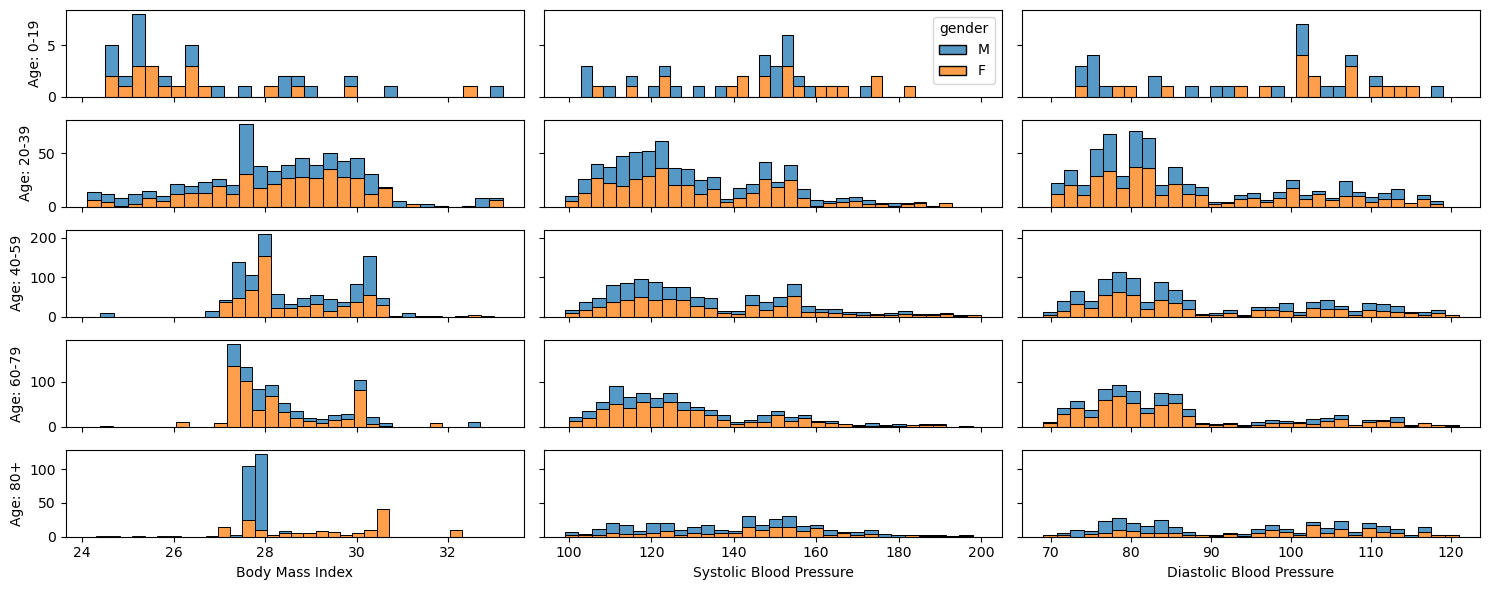

In [21]:
bins = [0, 20, 40, 60, 80, 120]
labels = ['0-19', '20-39', '40-59', '60-79', '80+']
obs_hyp_pivot['age_group'] = pd.cut(obs_hyp_pivot['age_at_observation_date'], bins=bins, labels=labels)

measurements = ['Body Mass Index', 'Systolic Blood Pressure', 'Diastolic Blood Pressure']
age_groups = obs_hyp_pivot['age_group'].cat.categories

fig, axes = plt.subplots(nrows=len(age_groups), ncols=len(measurements), figsize=(15, 6), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.4)

# Plot
for row_idx, age_group in enumerate(age_groups):
    data_age = obs_hyp_pivot[obs_hyp_pivot['age_group'] == age_group]
    for col_idx, measure in enumerate(measurements):
        ax = axes[row_idx, col_idx]
        show_legend = (row_idx == 0 and col_idx == 1) 
        sns.histplot(data=data_age,x=measure,hue='gender',ax=ax, kde=False, bins=30,multiple='stack', legend=show_legend )
        ax.set_ylabel(f"Age: {age_group}")


plt.tight_layout()
plt.show()



# 4 Report the crude, and adjusted (to the UK population as much as possible) prevalence of hypertension.

## 4.a Crude prevalence
To calculate the **crude prevalence** of hypertension, I computed the proportion of patients who had a hypertension diagnosis relative to my total sample size.


In [22]:
crude_prevalence = len(obs_hyp_pivot['patient'].unique()) / len(patients['id'].unique())
crude_prevalence

0.21695533272561532

## 4.b Adjusted prevalence
To calculate the adjusted prevalence of hypertension, I decided to use the same  age groups that for my distribution plot.
I used external UK population data from Office For National Statistics Mid 2023 and got the counts in the same 20 year intervals.


In [23]:
cases_by_age = obs_hyp_pivot.groupby('age_group')['patient'].nunique()
data = { "Age Groups": [ "0 to 4", "5 to 9", "10 to 14", "15 to 19", "20 to 24", "25 to 29","30 to 34", "35 to 39", "40 to 44", "45 to 49", "50 to 54", "55 to 59",
        "60 to 64", "65 to 69", "70 to 74", "75 to 79", "80 to 84", "85 to 89", "90 and over"],
    "Population": [3572007, 3925921, 4150287, 4011468, 4097542, 4427747, 4700198,
        4636593, 4446226, 4043242, 4522878, 4625265, 4181669, 3489709,3120459, 2843315, 1763312, 1095652, 611719]}

uk_population = pd.DataFrame(data)
uk_population['Population'].sum()

# Map each 5-year group to a 20-year interval
def map_to_20year(age_group):
    start_age = int(age_group.split(' ')[0])
    if start_age < 20:
        return '0-19'
    elif start_age < 40:
        return '20-39'
    elif start_age < 60:
        return '40-59'
    elif start_age < 80:
        return '60-79'
    else:
        return '80+'
        
uk_population['Age_20yr_Group'] = uk_population['Age Groups'].apply(map_to_20year)
# Aggregate population by 20-year groups
uk_population_20yr = uk_population.groupby('Age_20yr_Group')['Population'].sum().reset_index()

uk_population_20yr.head()

,Age_20yr_Group,Population
0,0-19,15659683
1,20-39,17862080
2,40-59,17637611
3,60-79,13635152
4,80+,3470683


I observed that 2020 had the highest number of observations, so I focused on this year for the prevalence calculation to better represent a specific time frame.

First, I filtered the dataset to include only observations from 2020, then kept just the first observation per patient within that year to avoid duplicate counting.

Next, I counted the number of patients with hypertension in each age group and calculated the total sample size for 2020.

Using the UK population data grouped by age, I mapped population counts to each age group and calculated weights based on their proportion of the total UK population.

Finally, I computed the age-specific sample prevalence and applied the UK population weights to estimate the weighted prevalence of hypertension for 2020, producing an age-adjusted prevalence estimate for that year.


In [24]:
# i found that the year with more observations is 2020 so I will use population from this year
obs_2020 = obs_hyp_pivot[obs_hyp_pivot['observation_date'].dt.year == 2020]
# Keep only the first observation per patient in 2020
first_obs_2020 = obs_2020.sort_values('observation_date').drop_duplicates('patient')
# Count  patients per age group
cases_by_age = first_obs_2020.groupby('age_group')['patient'].nunique()
#  sample size
total_sample = first_obs_2020['patient'].nunique()
# UK population mapping (same as before)
uk_population_dict = dict(zip(uk_population_20yr['Age_20yr_Group'], uk_population_20yr['Population']))
uk_total = sum(uk_population_dict.values())

df_summary = pd.DataFrame({'age_group': cases_by_age.index, 'cases': cases_by_age.values})
df_summary['sample_prevalence'] = df_summary['cases'] / total_sample
df_summary['uk_population'] = df_summary['age_group'].map(uk_population_dict)
df_summary['uk_population'] = pd.to_numeric(df_summary['uk_population'], errors='coerce')
df_summary['uk_weight'] = df_summary['uk_population'] / uk_total
df_summary['weighted_prevalence'] = df_summary['sample_prevalence'] * df_summary['uk_weight']

df_summary

,age_group,cases,sample_prevalence,uk_population,uk_weight,weighted_prevalence
0,0-19,2,0.010256,15659683,0.229395,0.002353
1,20-39,53,0.271795,17862080,0.261657,0.071117
2,40-59,89,0.456410,17637611,0.258369,0.117922
3,60-79,40,0.205128,13635152,0.199738,0.040972
4,80+,11,0.056410,3470683,0.050841,0.002868


In [25]:
adjusted_prevalence = df_summary['weighted_prevalence'].sum()
print(f"Age-adjusted prevalence: {adjusted_prevalence:.4f}")

Age-adjusted prevalence: 0.2352
